In [1]:
%matplotlib notebook

import numpy as np

# Synthetic Data (4 Layers, 10 Time Steps)

In [2]:
from multidynet.datasets import simple_dynamic_multilayer_network
from multidynet.plots import plot_network

lmbda = np.array([[1., 1.],
                  [0.5, -0.5],
                  [-2.0, 2.0],
                  [-1., -1.]])

Y, X, lmbda, delta, probas = simple_dynamic_multilayer_network(
    n_nodes=100, n_time_steps=20,
    tau_sq=4.0, sigma_sq=0.01,
    lmbda=lmbda, 
    assortative_reference=False,
    random_state=0)

## Layer 1

<IPython.core.display.Javascript object>


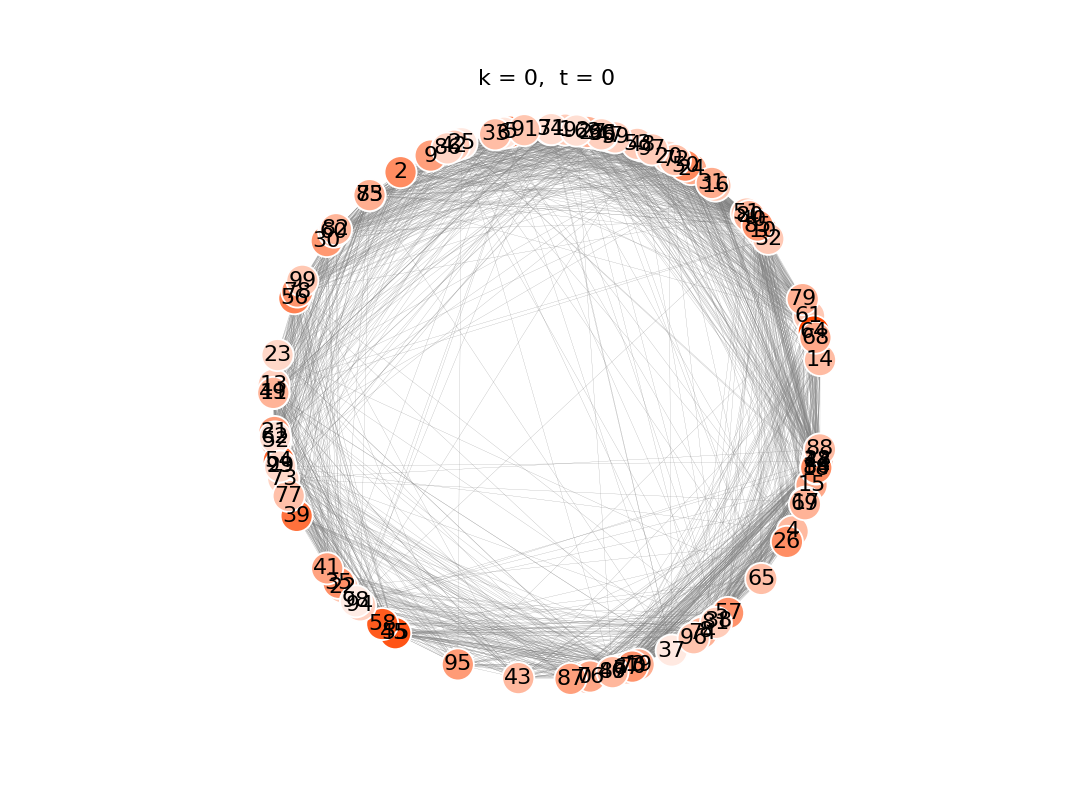

Text(0.5, 1.0, 'k = 0,  t = 0')

In [75]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 2

<IPython.core.display.Javascript object>


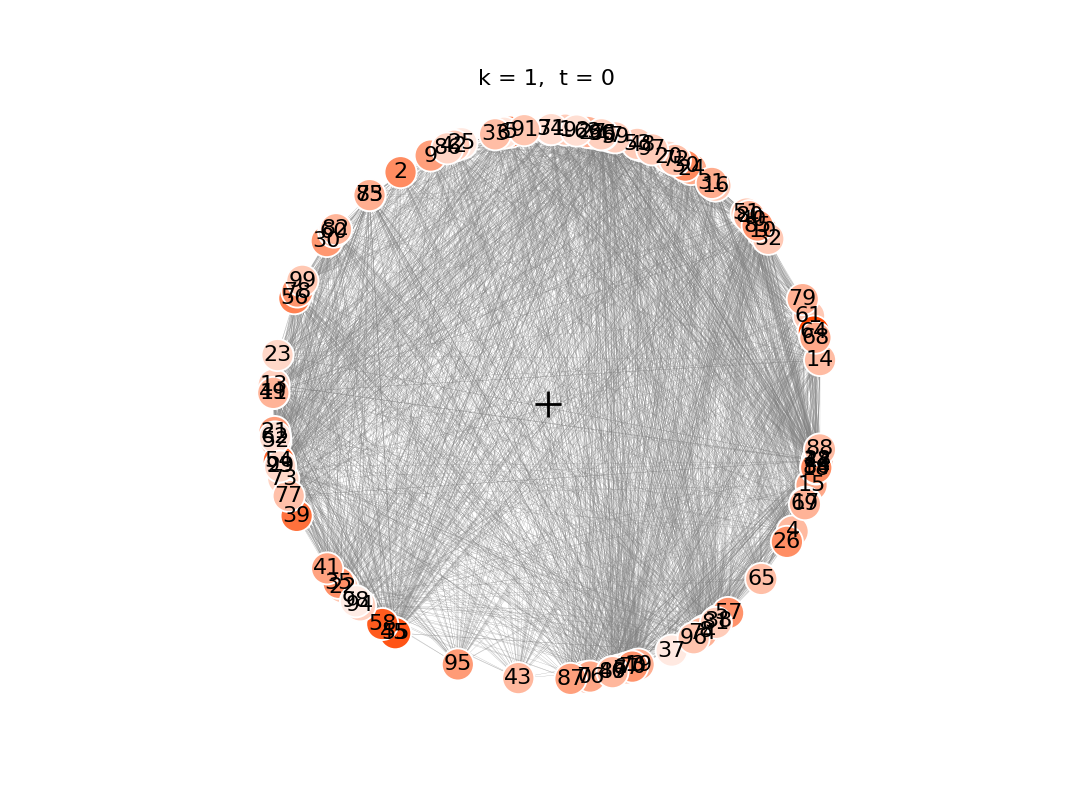

Text(0.5, 1.0, 'k = 1,  t = 0')

In [4]:
t = 0
k = 1

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 3

<IPython.core.display.Javascript object>


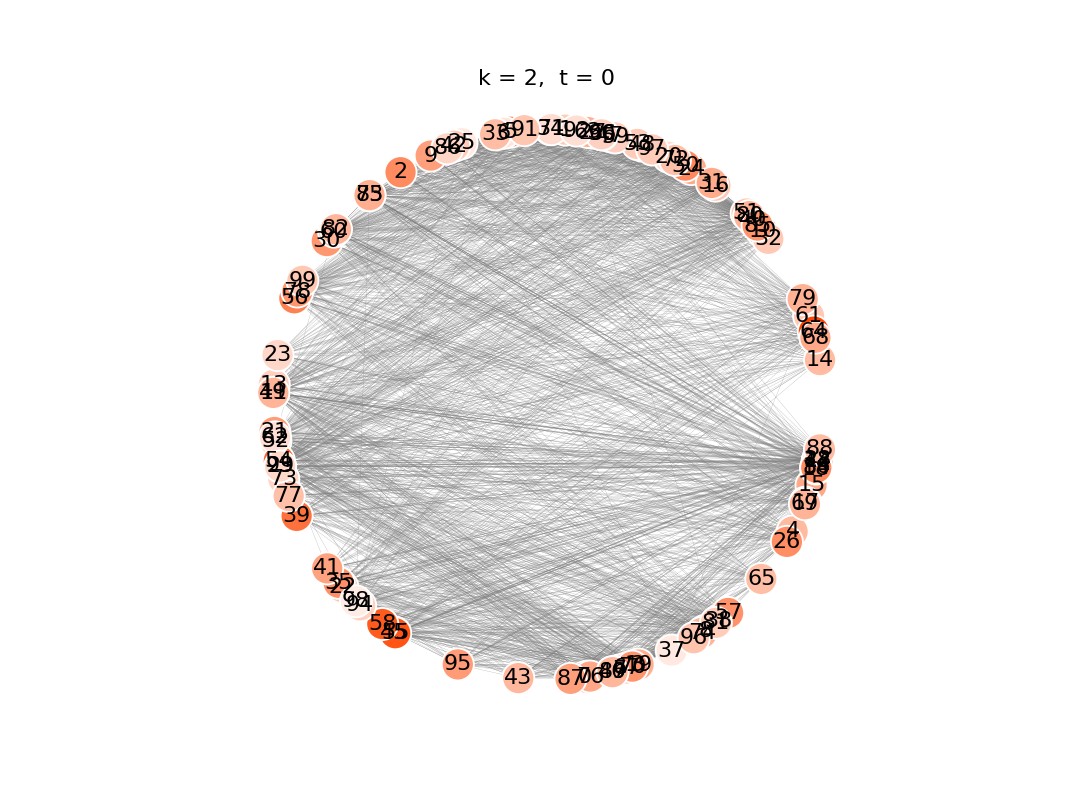

Text(0.5, 1.0, 'k = 2,  t = 0')

In [77]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 4

<IPython.core.display.Javascript object>


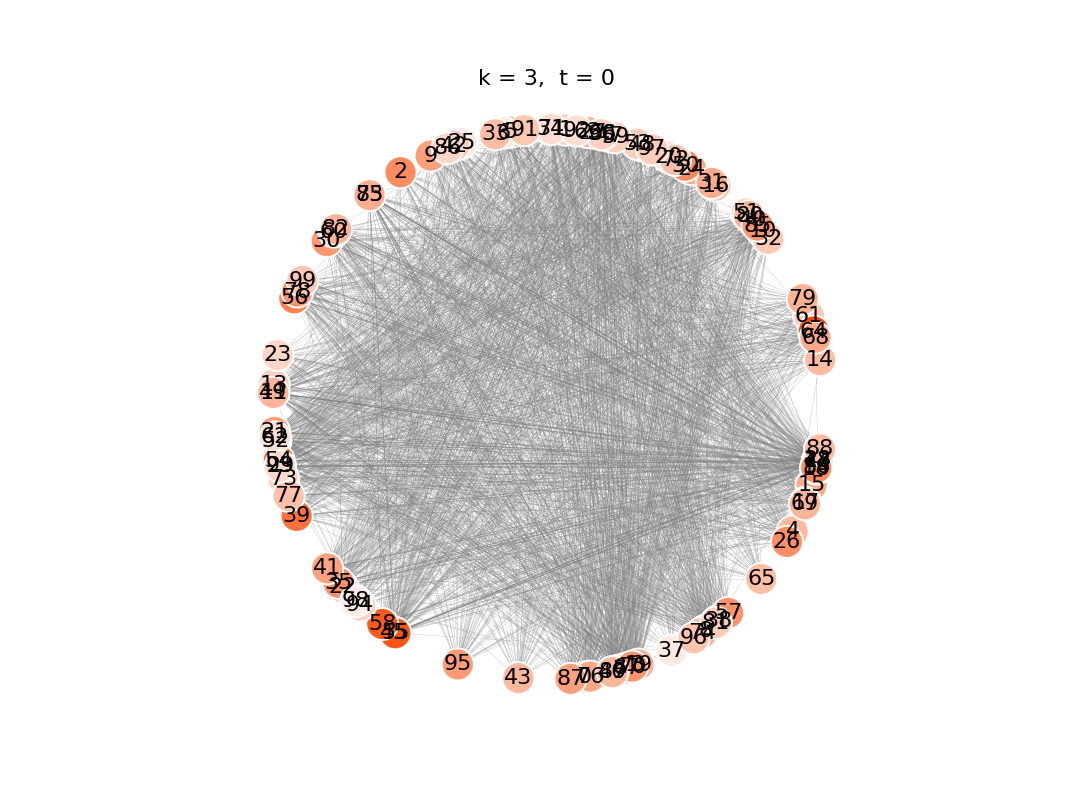

Text(0.5, 1.0, 'k = 3,  t = 0')

In [78]:
t = 0
k = 3

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

# Model Estimation

In [36]:
from multidynet import DynamicMultilayerNetworkLSM
from multidynet.model_selection import train_test_split

# Hold-out 20% of dyads for testing
Y_train, test_indices = train_test_split(Y, test_size=0.2)

model = DynamicMultilayerNetworkLSM(max_iter=500, 
                                    a=4.0, b=20.0, c=10, d=1.0, 
                                    lambda_var_prior=4., 
                                    lambda_odds_prior=2,
                                    delta_var_prior=4.,
                                    tol=1e-2,
                                    n_jobs=-1,
                                    n_init=8,
                                    random_state=123)
model.fit(Y_train)

/Users/joshua/myworkspace/multidynet/multidynet/multidynet.py:349: ConvergenceWarning: Best model did not converge. Try a different random initialization, or increase max_iter, tol or check for degenerate data.
  'or check for degenerate data.', ConvergenceWarning)


<IPython.core.display.Javascript object>


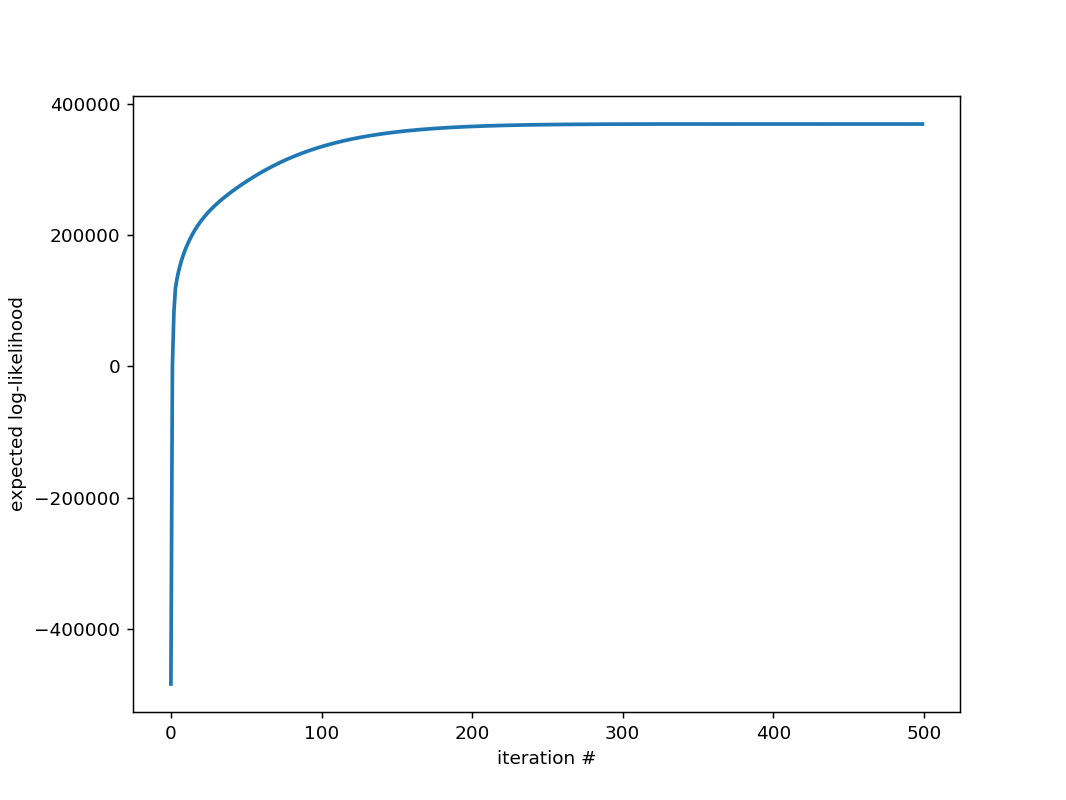

Text(0.5, 0, 'iteration #')

In [37]:
fig, ax= plt.subplots(figsize=(8, 6))
ax.plot(model.logp_, lw=2)
ax.set_ylabel('expected log-likelihood')
ax.set_xlabel('iteration #')

# Parameter Estimates

# Assortativity Parameters $\Lambda_k$

In [38]:
model.lambda_

array([[ 1.        ,  1.        ],
       [ 0.50980569, -0.51979195],
       [-1.81793407,  1.81609417],
       [-0.9970641 , -0.99972178]])

# Sociability Parameters $\delta_k^i$

In [39]:
np.mean((model.delta_ - delta) ** 2)

0.04463856464366613

# $\tau^2$

In [40]:
model.tau_sq_

3.6450481577362406

# $\sigma^2$

In [41]:
model.sigma_sq_

3.1599546706647397

## Latent Space 

<IPython.core.display.Javascript object>


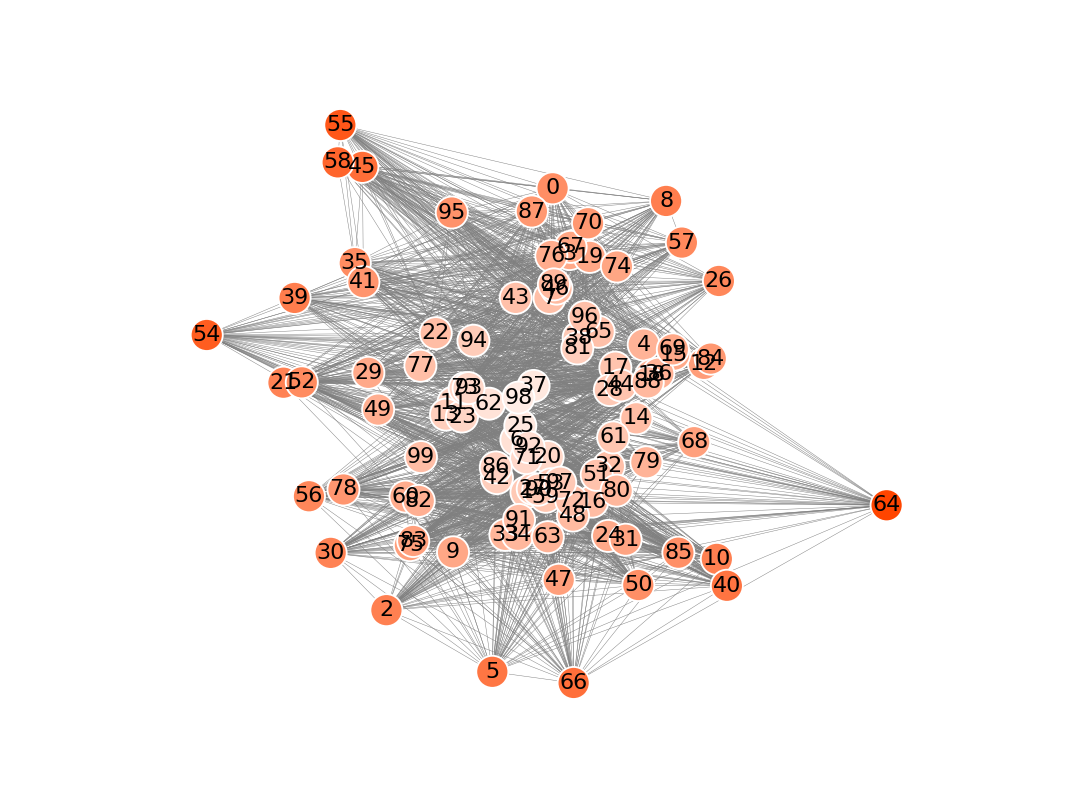

In [96]:
from multidynet.plots import plot_network

t = 0
k = 2
ax = plot_network(Y[k, t],model.X_[t], normalize=False, with_labels=True)

# Performance Diagnostics

## In-sample AUC

In [42]:
model.auc_

0.9633648307023954

## Held-out AUC

In [43]:
from multidynet.metrics import calculate_auc

calculate_auc(Y, model.probas_, test_indices)

0.9603801571113602

## Connection Probability Estimates

<IPython.core.display.Javascript object>


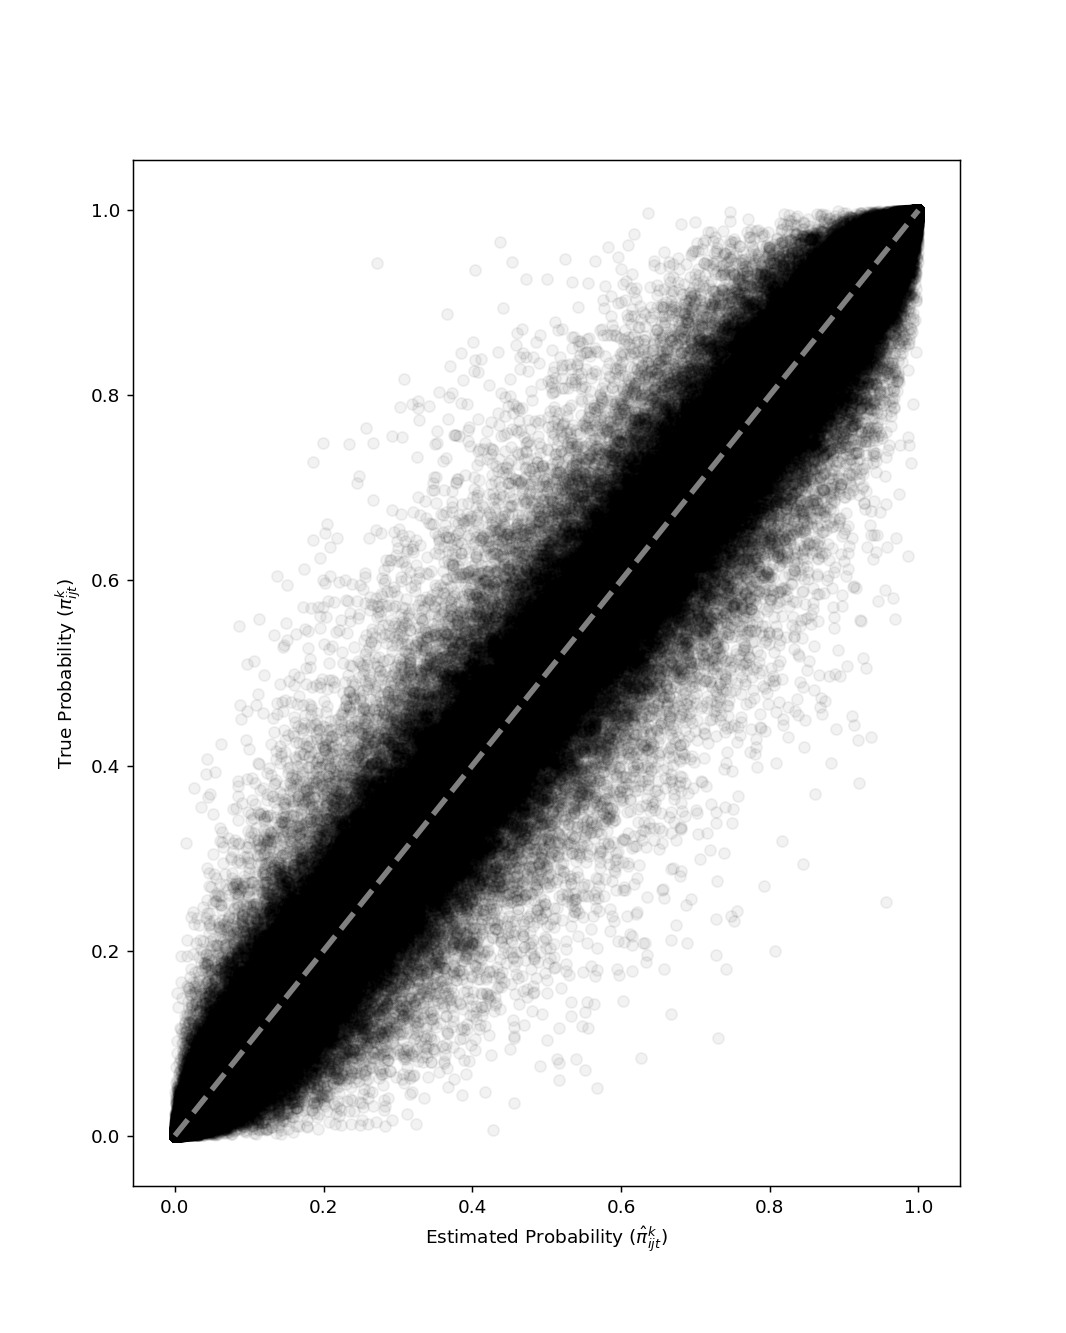

Text(0.5, 0, 'Estimated Probability ($\\hat{\\pi}_{ijt}^k$)')

In [44]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))

p_true = np.zeros((n_layers, n_time_steps, n_dists))
p_est = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = model.probas_[k, t]
        
        deltak = delta[k].reshape(-1, 1)
        d_true = expit(np.add(deltak, deltak.T)+ np.dot(X[t] * lmbda[k], X[t].T))

        indices = np.tril_indices_from(d_est, k=-1)
        p_true[k, t] = d_true[indices]
        p_est[k, t] = d_est[indices]

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, '--', color='gray', lw=3)
ax.scatter(p_est.ravel(), p_true.ravel(), alpha=0.05, c='k')
ax.set_ylabel('True Probability ($\pi_{ijt}^k$)')
ax.set_xlabel('Estimated Probability ($\hat{\pi}_{ijt}^k$)')

In [47]:
import pickle

pickle.dump(model, open('model_types_n100_t20.pkl', 'wb'))

In [3]:
import pickle

model = pickle.load(open('model_types_n100_t20.pkl', 'rb'))

In [5]:
from multidynet.metrics import score_latent_space_individual

mse, perm = score_latent_space_individual(X, model.X_)

In [7]:
perm

(0, 1)

In [9]:
import itertools

def calculate_mse(X_true, X_pred):
    """Try all column permutations and feature flipping combinations to 
    determine the MSE of the estimate"""
    n_features = X_true.shape[1]
    best_mse = np.inf
    best_perm = None
    for perm in itertools.permutations(np.arange(n_features)):
        X = X_pred[..., perm]
        
        # no flip 
        mse = np.mean((X_true - X_pred) ** 2)
        if mse < best_mse:
            best_mse = mse
            best_perm = perm
        
        # loops through single feature flips
        for p in range(n_features):
            Xp = X.copy()
            Xp[..., p] = -X[..., p]
            mse = np.mean((X_true - Xp) ** 2)
            if mse < best_mse:
                best_mse = mse
                best_perm = perm
                
        # loop through all feature combinations
        for k in range(2, n_features + 1):
            for combo in itertools.combinations(range(n_features), k):
                Xp = X.copy()
                Xp[..., combo] = -X[..., combo]
                mse = np.mean((X_true - Xp) ** 2)
                if mse < best_mse:
                    best_mse = mse
                    best_perm = perm
    
    return best_mse, best_perm

res = 0
for t in range(X.shape[0]):
    mse, perm = calculate_mse(X[t], model.X_[t])
    res += mse
    
res / X.shape[0]

0.06996093676876805

In [8]:
np.mean((lmbda - model.lambda_[..., perm]) ** 2)

0.008433240678121312

In [9]:
np.mean((delta - model.delta_)**2)

0.04463856464366613

In [10]:
np.mean((model.probas_ - probas) ** 2)

0.002108546665219802

In [11]:
model.converged_

False

<IPython.core.display.Javascript object>


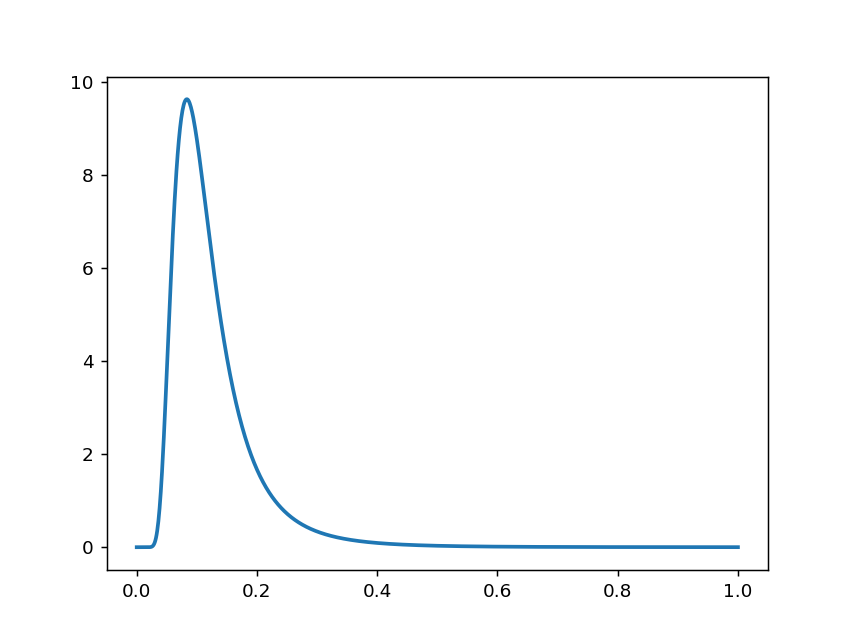

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_invgamma(a, b):
    x = np.linspace(0, 1, 1000)
    y = stats.invgamma.pdf(x, a=a/2., scale=b/2.)
    plt.plot(x, y, lw=2)
    
plot_invgamma(10., 1.)

<IPython.core.display.Javascript object>


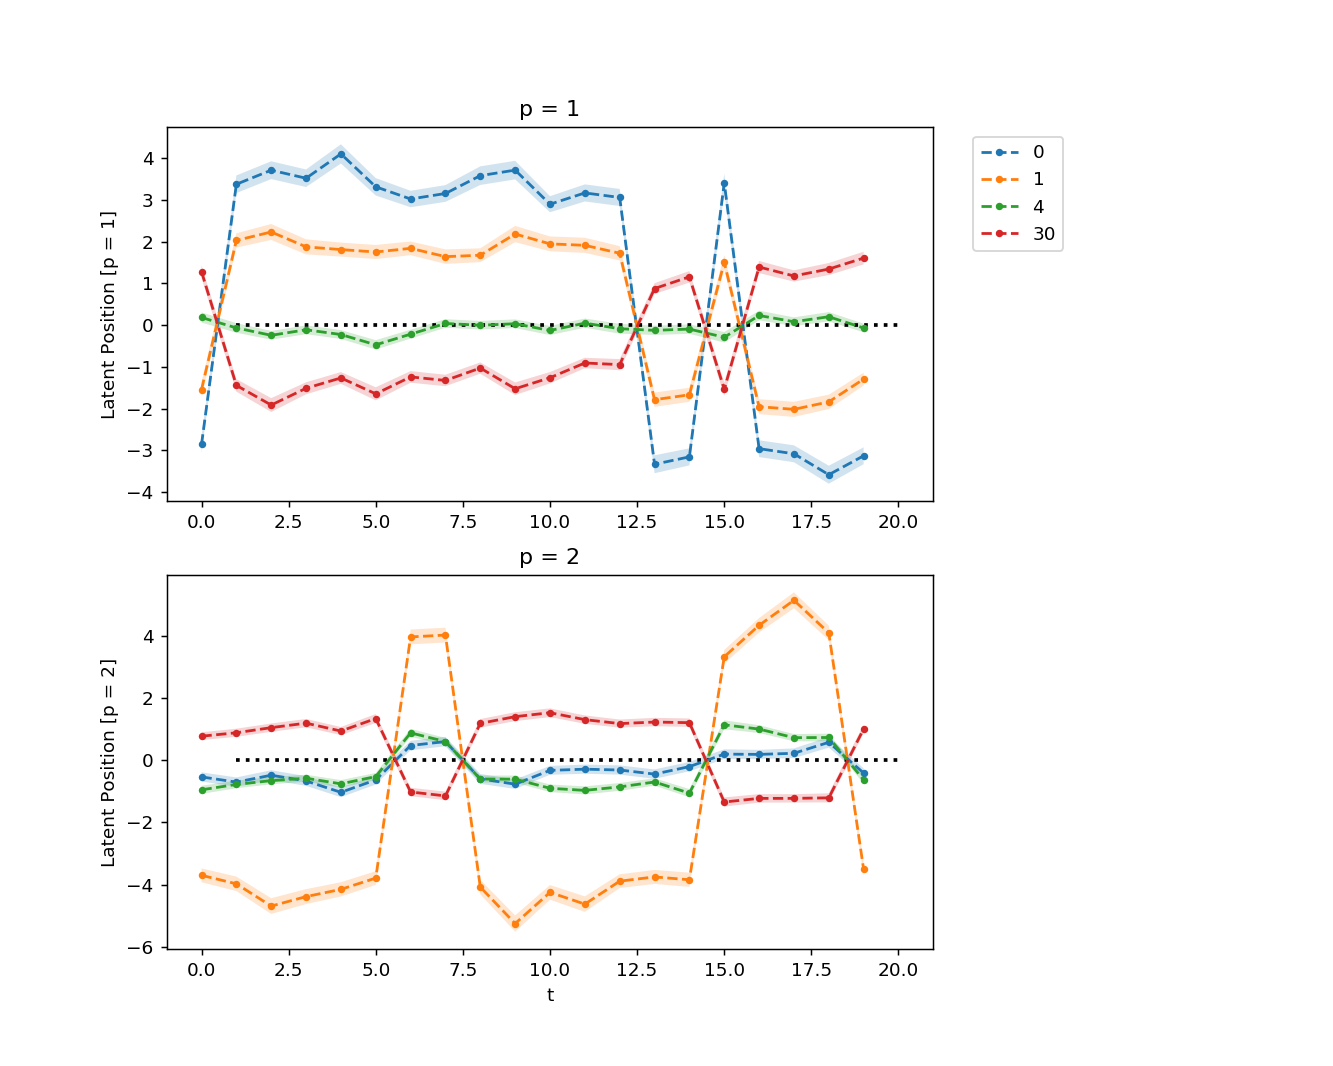

In [50]:
from multidynet.plots import plot_node_trajectories

ax = plot_node_trajectories(model, [0, 1, 4, 30],
                           q_alpha=0.05, linestyle='.--')

In [51]:
X[0, :, 0]

array([ 3.52810469,  1.95747597,  3.73511598,  1.90017684, -0.2064377 ,
        0.28808714,  1.52207545,  0.88772647,  2.98815815,  0.6261354 ,
       -5.10597963,  1.7288724 ,  4.53950925,  0.09151703,  3.06555843,
        0.30989485, -1.7755715 , -0.6958243 ,  2.46058136, -0.77465363,
       -2.09710593, -3.41254038, -1.01930436, -2.50559072, -3.2277957 ,
       -1.79093312, -1.02161028, -0.05636446,  0.13303444, -1.26864419,
       -1.3449209 , -1.62629256,  0.35485228, -3.26039669, -1.81459673,
        1.45818112,  2.27880137,  0.80468328, -1.7415943 , -0.62310506,
       -2.33029968,  0.93132488,  2.97650439,  2.35755914, -2.14150524,
       -0.80635389,  0.41654996,  0.71273279,  0.02100004,  0.25382419,
        3.76630139, -2.54097   , -2.34624681, -0.82723796,  3.84588405,
        3.73511792, -1.72245137, -0.53600674,  1.89450394,  1.22815874,
        0.75285106,  0.59647635, -1.38913572, -0.8703071 ,  1.34458951,
       -1.53983215, -1.34866532, -1.27169216,  1.15318163,  0.79

In [52]:
np.repeat(np.inf, 10)

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

In [ ]:
score_latent_space